# ***USER BEHAVIOUR ANALYSIS***

### **Task**

| Subtask                    | How                                                                 |
| -------------------------- | ------------------------------------------------------------------- |
| Parse conversation logs    | Use Pandas groupby on ticket\_id sorted by timestamp                |
| Extract conversation flows | Track message order per ticket                                      |
| Tag users                  | Based on support category (topic modeling), sentiment, and sequence |
| Cluster flows              | Use clustering (KMeans, DBSCAN) on vectorized flow features         |
| Exclude resolved tickets   | Use `status == resolved` or similar flag                            |
| Visualize                  | Sankey, bar plots, line plots, heatmaps                             |


### **Tools**

| Need               | Tools                                                     |
| ------------------ | --------------------------------------------------------- |
| Sentiment Analysis | `VADER`, `TextBlob`, `transformers (BERT)`                |
| Topic Modeling     | `BERTopic`, `LDA`, `TF-IDF + KMeans`                      |
| Clustering         | `KMeans`, `DBSCAN`, `HDBSCAN`                             |
| Visualization      | `matplotlib`, `seaborn`, `plotly`, `networkx`, `graphviz` |
| Workflow           | `Jupyter`, `pandas`, `sklearn`, `scipy`, `nltk/spacy`     |


### **Visualisation**

| Type                            | Tool                              |
| ------------------------------- | --------------------------------- |
| Sentiment over time             | Line chart (Matplotlib / Seaborn) |
| Flow types                      | Pie/Bar chart                     |
| Sankey diagram (flow direction) | `plotly`                          |
| MBTI distribution               | Seaborn or plotly                 |
| Heatmap (Issue vs Sentiment)    | `seaborn.heatmap`                 |
| BERTopic topic map              | Built-in UMAP visualizer          |


# ***CODE***

### **Config**

In [16]:
import sqlite3
import os
import yaml
import pandas as pd

# config.yaml
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [17]:
csv_path = config['data']['raw_csv_path']
sqlite_path = config['data']['sqlite_db_path']
raw_table = config['sqlite']['raw_table']
interaction_table = config['sqlite']['interaction_table']
parsed_conversations = config['output']['parsed_conversations_path']
tagged_parsed_conversations_path = config['output']['tagged_conversations_path']

### **SQLite Preview**

In [18]:
# Connect to SQLite
conn = sqlite3.connect(sqlite_path)
cursor = conn.cursor()

In [19]:
# Load DB
# Preview the interaction table
df_preview = pd.read_sql(f"SELECT * FROM {interaction_table} LIMIT 10000;", conn)
display(df_preview)

,conversation_id,customer_id,agent_id,customer_text,agent_response,created_at
0,3,115712,sprintcare,sprintcare i have sent several private message...,115712 i understand i would like to assist you...,2017-10-31 22:08:27+00:00
1,5,115712,sprintcare,sprintcare i did,115712 please send us a private message so tha...,2017-10-31 21:49:35+00:00
2,8,115712,sprintcare,sprintcare is the worst customer service,115712 can you please send us a private messag...,2017-10-31 21:45:10+00:00
3,12,115713,sprintcare,sprintcare you gonna magically change your con...,115713 this is saddening to hear please shoot ...,2017-10-31 22:04:47+00:00
4,16,115713,sprintcare,sprintcare since i signed up with yousince day 1,115713 we understand your concerns and wed lik...,2017-10-31 20:00:43+00:00
...,...,...,...,...,...,...
9995,28933,122366,AmazonHelp,amazonhelp do fast it is taking so much time a...,122366 i totally understand your frustration a...,2017-11-06 14:01:33+00:00
9996,28923,122366,AmazonHelp,amazonhelp sir u r making me foolwhen i cant r...,122366 account please reach out here amp well ...,2017-11-01 13:55:36+00:00
9997,28923,122366,AmazonHelp,amazonhelp sir u r making me foolwhen i cant r...,122366 ideally any account change will be foll...,2017-11-01 13:55:36+00:00
9998,28918,122366,AmazonHelp,amazonhelp inconimg option not availble on the...,122366 i see that you are trying to send a rep...,2017-11-01 12:42:41+00:00


### **Parsing and Deduplicating conversations from interaction_table**

In [20]:
df = pd.read_sql(f"SELECT * FROM {interaction_table};", conn)

In [21]:
# src/components/conversation_parser.py

import pandas as pd
def build_conversation_flows(df: pd.DataFrame):
    grouped = df.sort_values(by='created_at').groupby('customer_id')
    conversation_flows = []

    for customer_id, group in grouped:
        conversation = []
        seen = set()

        for _, row in group.iterrows():
            user_msg = ("user", row['customer_text'], row['created_at'])
            agent_msg = ("agent", row['agent_response'], row['created_at'])

            if user_msg not in seen:
                conversation.append({
                    "sender": user_msg[0],
                    "text": user_msg[1],
                    "timestamp": user_msg[2]
                })
                seen.add(user_msg)

            if agent_msg not in seen:
                conversation.append({
                    "sender": agent_msg[0],
                    "text": agent_msg[1],
                    "timestamp": agent_msg[2]
                })
                seen.add(agent_msg)

        agent_id = group['agent_id'].mode().values[0] if not group['agent_id'].isnull().all() else None

        conversation_flows.append({
            "customer_id": customer_id,
            "agent_id": agent_id,
            "conversation": conversation
        })

    return conversation_flows


### **Total Unique Customer IDs**

In [22]:
print(df['customer_id'].nunique())
print(df['customer_id'].value_counts().head(500000))

422461
customer_id
116421    236
203476    186
158494    174
326613    168
130560    154
         ... 
566008      2
566009      2
565994      2
565995      2
565996      2
Name: count, Length: 422461, dtype: int64


In [23]:
flows = build_conversation_flows(df)

In [24]:
print(f"Total deduplicated customer conversations parsed: {len(flows)}")

Total deduplicated customer conversations parsed: 422461


### **Parsed Sample**

In [25]:
import json
print(json.dumps(flows[78], indent=2, ensure_ascii=False))

{
  "customer_id": "115774",
  "agent_id": "AdobeCare",
  "conversation": [
    {
      "sender": "user",
      "text": "115769 are there any plans to add a fast crop mode for the ipad version of lr it takes too many taps and slows down workflow",
      "timestamp": "2017-10-28 13:37:52+00:00"
    },
    {
      "sender": "agent",
      "text": "115774 hi there you may suggest it as a feature request at tanuj",
      "timestamp": "2017-10-28 13:37:52+00:00"
    }
  ]
}


In [26]:
for flow in flows[:4]:
    print(json.dumps(flow, indent=2, ensure_ascii=False))
    print("=" * 80)

{
  "customer_id": "10026",
  "agent_id": "ChaseSupport",
  "conversation": [
    {
      "sender": "user",
      "text": "screw you 116016 and your stupid blueprint program i never signed up for this crap and now you’re going to charge me interest fees",
      "timestamp": "2017-10-05 00:08:01+00:00"
    },
    {
      "sender": "agent",
      "text": "10026 im sorry to hear this and id like to see what i can do to help will you please dm more details cm",
      "timestamp": "2017-10-05 00:08:01+00:00"
    },
    {
      "sender": "user",
      "text": "chasesupport actually it just doesn’t work in safari but that’s still pretty bad",
      "timestamp": "2017-11-06 15:45:29+00:00"
    },
    {
      "sender": "agent",
      "text": "10026 we apologize for the inconvenience we recommend to clear your cache amp cookies and navigate to the site without a bookmark an",
      "timestamp": "2017-11-06 15:45:29+00:00"
    }
  ]
}
{
  "customer_id": "100363",
  "agent_id": "Delta",
  "convers

### **Saving parsed convs in JSON**

In [27]:
import json
from pathlib import Path

with open(parsed_conversations, 'w', encoding='utf-8') as f:
    json.dump(flows, f, indent=2, default=str)

print("Saved parsed conversations.")

Saved parsed conversations.


### **Sentiment Analysis & Issue Type Classification**

Hierarchial Classification of Issue Types

In [28]:
HIGH_LEVEL_LABELS = [
    "Technical Issue", "Account & Payment", "Delivery & Orders",
    "Product & Services", "Customer Experience", "Miscellaneous"
]

# Fine-grained issue types
FINE_LABELS = [
    "technical issue", "bug or glitch", "login problem", "app crash or freeze",
    "slow performance", "update failure", "account issue", "billing problem",
    "payment failure", "subscription issue", "unauthorized charge",
    "delivery problem", "order not received", "damaged item", "wrong item received",
    "missing package", "product question", "pricing", "service unavailable",
    "feature request", "refund", "complaint", "feedback", "praise", "cancellation"
]

FINE_TO_HIGH_MAP = {
    "technical issue": "Technical Issue",
    "bug or glitch": "Technical Issue",
    "login problem": "Technical Issue",
    "app crash or freeze": "Technical Issue",
    "slow performance": "Technical Issue",
    "update failure": "Technical Issue",

    "account issue": "Account & Payment",
    "billing problem": "Account & Payment",
    "payment failure": "Account & Payment",
    "subscription issue": "Account & Payment",
    "unauthorized charge": "Account & Payment",

    "delivery problem": "Delivery & Orders",
    "order not received": "Delivery & Orders",
    "damaged item": "Delivery & Orders",
    "wrong item received": "Delivery & Orders",
    "missing package": "Delivery & Orders",

    "product question": "Product & Services",
    "pricing": "Product & Services",
    "service unavailable": "Product & Services",
    "feature request": "Product & Services",

    "refund": "Customer Experience",
    "complaint": "Customer Experience",
    "feedback": "Customer Experience",
    "praise": "Customer Experience",
    "cancellation": "Customer Experience"
}

In [30]:
# src/components/sentiment_analyser.py

from transformers import pipeline

# Load DistilBERT fine-tuned on SST-2
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def get_sentiment(text):
    # Optional: truncate to avoid max token length issues
    text = text[:1000]
    result = sentiment_pipeline(text)[0]
    label = result['label'].lower()  # 'positive' or 'negative'
    score = float(result['score'])
    return label, score


d:\Anaconda\envs\riverline\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu


In [31]:
# src/components/issue_type_classifier.py

from transformers import pipeline

zero_shot_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

def get_issue_tags(text):
    result = zero_shot_classifier(text, FINE_LABELS)
    fine_label = result['labels'][0]
    fine_score = float(result['scores'][0])
    high_label = FINE_TO_HIGH_MAP.get(fine_label, "Miscellaneous")
    return {
        "fine_label": fine_label,
        "fine_confidence": fine_score,
        "high_label": high_label
    }

Device set to use cpu


In [32]:
# src/components/tagger.py

# Load flows from saved JSON file
with open(parsed_conversations, 'r', encoding='utf-8') as f:
    flows = json.load(f)

In [ ]:
import random
sampled_flows = random.sample(flows, 1000) # for analysis of user sentiments

In [36]:
from tqdm import tqdm

tagged_conversations = []

for convo in tqdm(sampled_flows, desc="Tagging conversations"): # replace sample_flows with flows here
    # Issue type tagging is still done on the entire conversation
    full_text = " ".join([turn['text'] for turn in convo['conversation']])
    issue_tags = get_issue_tags(full_text)

    # Per-message sentiment tagging (only user messages)
    for turn in convo['conversation']:
        if turn['sender'] == 'user':
            sentiment_label, sentiment_confidence = get_sentiment(turn['text'])
            turn['sentiment'] = {
                'label': sentiment_label,
                'confidence': sentiment_confidence
            }

    # Add high-level metadata
    convo['issue_type'] = {
        'high_level': issue_tags['high_label'],
        'fine_grained': issue_tags['fine_label'],
        'confidence': issue_tags['fine_confidence']
    }

    tagged_conversations.append(convo)

Tagging conversations: 100%|██████████| 1000/1000 [4:28:59<00:00, 16.14s/it] 


In [47]:
# Save
with open(tagged_parsed_conversations_path, 'w', encoding='utf-8') as f:
    json.dump(tagged_conversations, f, indent=2, default=str)

print(f" Saved {len(tagged_conversations)} tagged conversations to {tagged_parsed_conversations_path}")

 Saved 1000 tagged conversations to D:/IIT BBS/Job Resources/Riverline/Riverline_NBA_system/outputs/json/parsed_conversations_tagged.json


### **Conversation Flow Modelling**

| Insight Type                                  | Use in NBA                                                       |
| --------------------------------------------- | ---------------------------------------------------------------- |
| Sentiment trajectories                        | Understand when to escalate, appease, or upsell                  |
| Dialogue structure (turn count, topic shifts) | Predict abandonment or dissatisfaction                           |
| Clustered flow patterns (BERTopic etc.)       | Create templates of frequent issues/resolutions                  |
| Escalation triggers                           | Learn what triggers negative sentiment or long resolution chains |
| Agent behavioral patterns                     | Improve agent response models                                    |


In [51]:
# Sentiment Trajectory Analysis

import json
from datetime import datetime

# Load the tagged conversations (1000 sample file)
with open(r'..\outputs\json\parsed_conversations_tagged.json', encoding='utf-8') as f:
    tagged_conversations_ = json.load(f)


In [52]:
from datetime import datetime

for convo in tagged_conversations_:
    sentiment_trajectory = []

    for turn in convo['conversation']:
        if turn['sender'] == 'user' and 'sentiment' in turn:
            timestamp = datetime.fromisoformat(turn['timestamp'].replace("Z", "+00:00"))
            sentiment_trajectory.append({
                "timestamp": timestamp.isoformat(),
                "sentiment": turn['sentiment']['label'],
                "confidence": turn['sentiment']['confidence']
            })

    convo['sentiment_trajectory'] = sentiment_trajectory

# Save updated file with sentiment trajectories
with open(r'..\outputs\json\parsed_conversations_sentiment_trajectory.json', 'w', encoding='utf-8') as f:
    json.dump(tagged_conversations_, f, indent=2, ensure_ascii=False)

print("✅ Sentiment trajectories saved for all flows.")

✅ Sentiment trajectories saved for all flows.


In [53]:
# Visualising Sentiment Trajectories

sentiment_to_score = {
    "negative": -1,
    "neutral": 0,
    "positive": 1
}

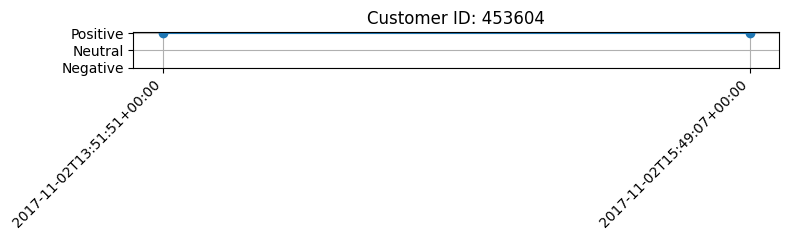

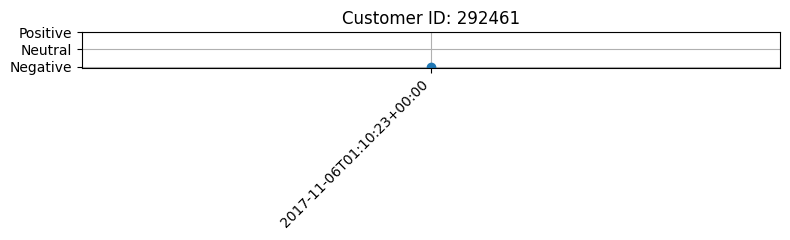

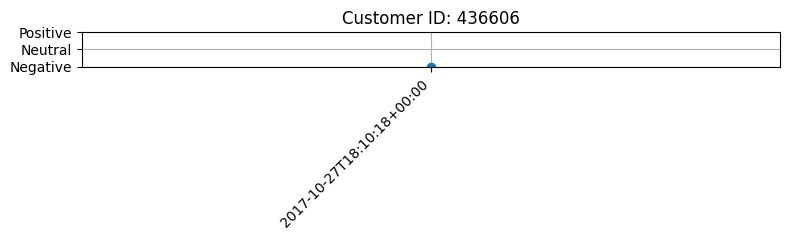

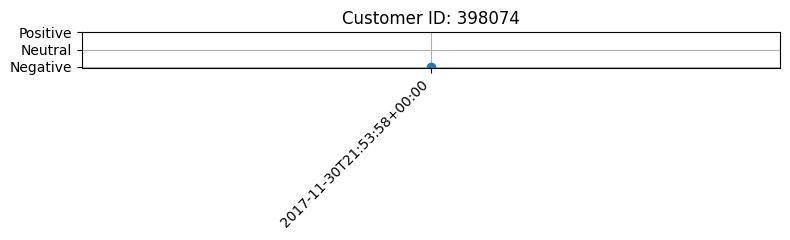

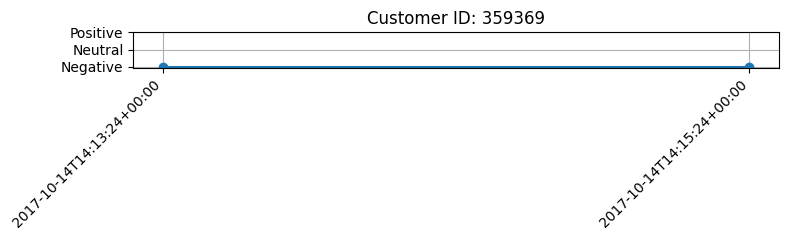

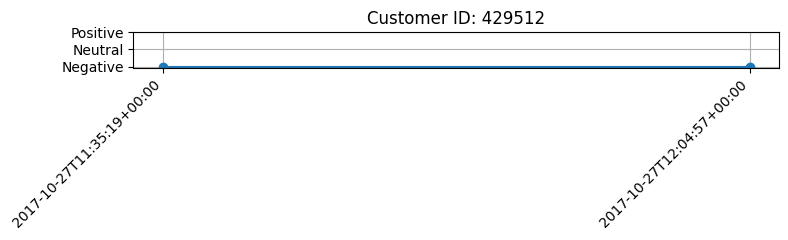

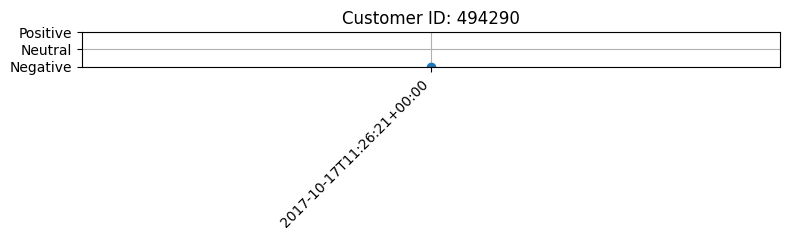

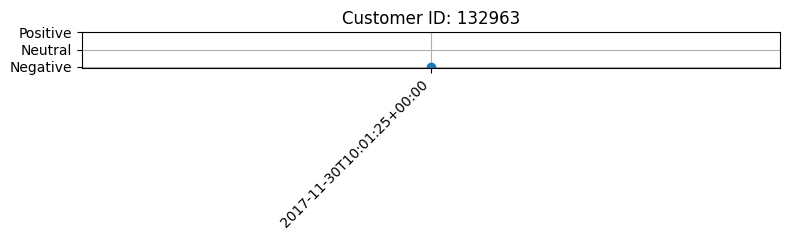

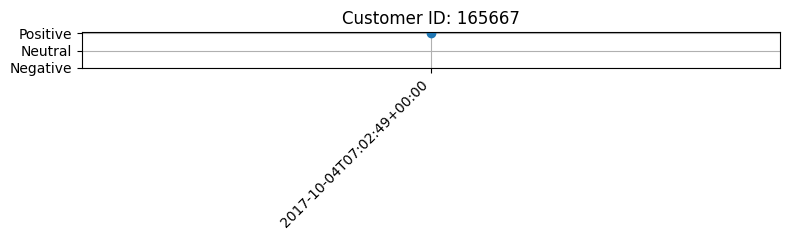

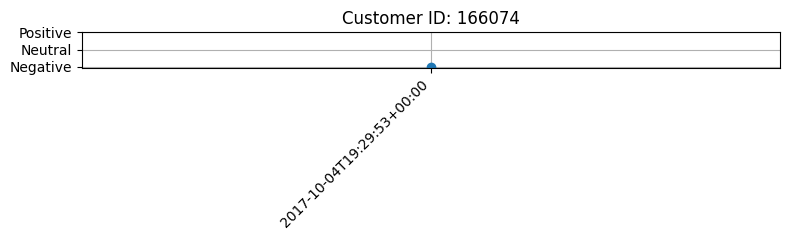

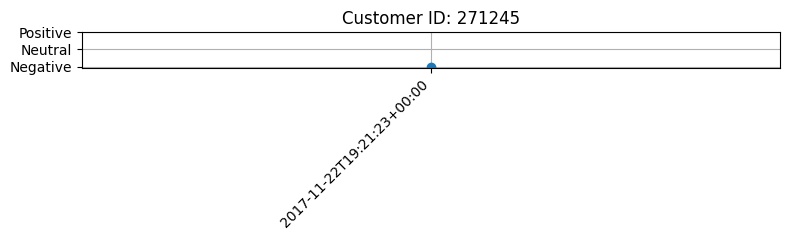

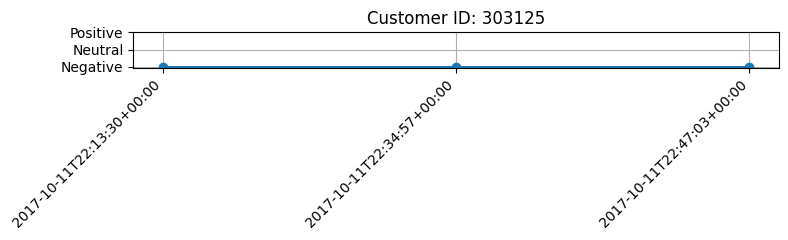

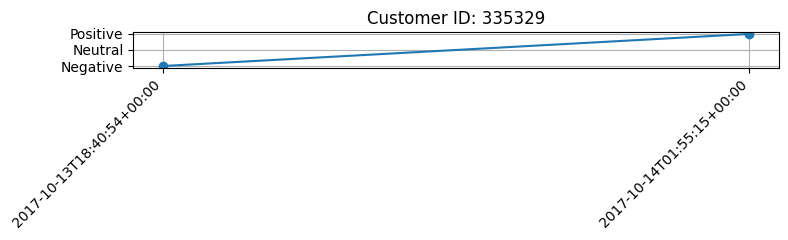

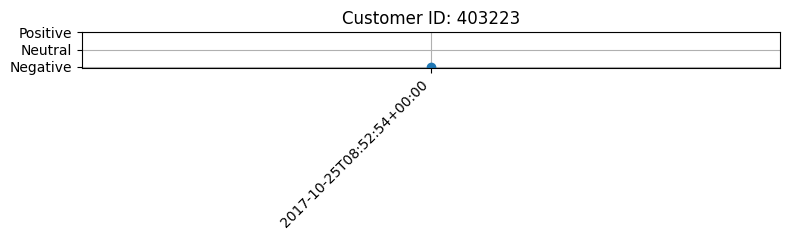

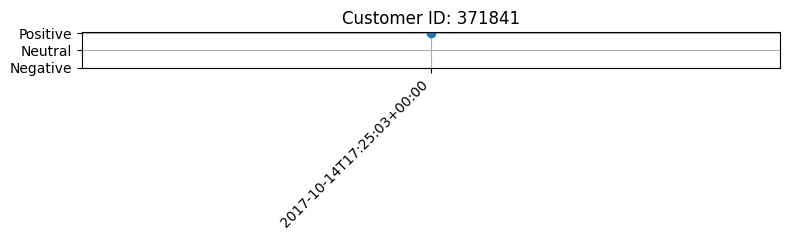

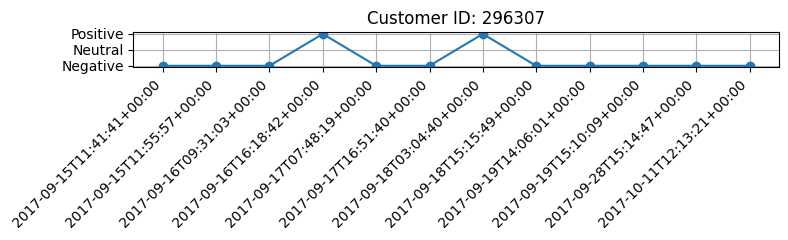

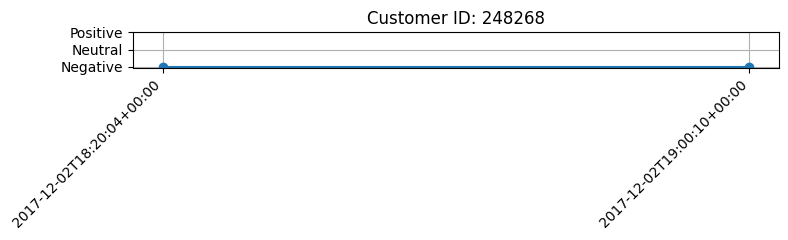

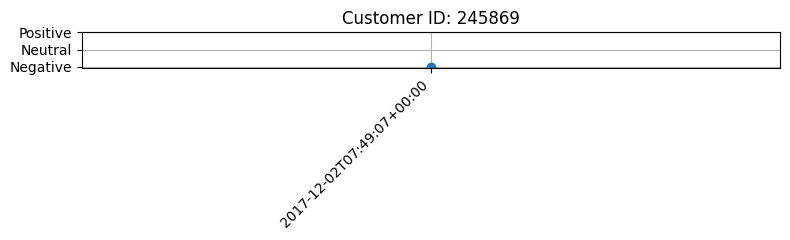

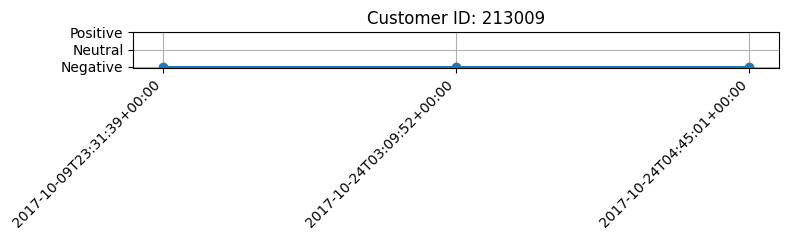

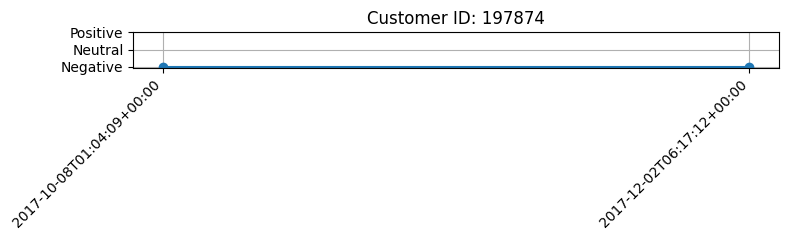

In [57]:
import matplotlib.pyplot as plt
import random

sentiment_to_score = {"negative": -1, "neutral": 0, "positive": 1}
score_to_sentiment = {v: k for k, v in sentiment_to_score.items()}

# Select random sample
sample_flows = random.sample(tagged_conversations, 20)

for convo in sample_flows:
    trajectory = convo.get('sentiment_trajectory', [])
    if not trajectory:
        continue

    scores = [sentiment_to_score[step['sentiment']] for step in trajectory]
    timestamps = [step['timestamp'] for step in trajectory]
    
    plt.figure(figsize=(8, 2.5))
    plt.plot(range(len(scores)), scores, marker='o')
    plt.title(f"Customer ID: {convo['customer_id']}")
    plt.xticks(range(len(scores)), timestamps, rotation=45, ha='right')
    plt.yticks([-1, 0, 1], ['Negative', 'Neutral', 'Positive'])
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [58]:
def classify_trajectory(scores):
    if not scores or len(scores) < 2:
        return "stable"
    
    if scores[-1] > scores[0]:
        return "improving"
    elif scores[-1] < scores[0]:
        return "worsening"
    elif all(s == scores[0] for s in scores):
        return "stable"
    else:
        return "mixed"

trajectory_stats = {"improving": 0, "worsening": 0, "stable": 0, "mixed": 0}

for convo in tagged_conversations:
    trajectory = convo.get('sentiment_trajectory', [])
    scores = [sentiment_to_score[step['sentiment']] for step in trajectory]

    category = classify_trajectory(scores)
    convo['trajectory_category'] = category
    trajectory_stats[category] += 1

# Print stats
for cat, count in trajectory_stats.items():
    print(f"{cat.capitalize()}: {count} conversations")

Improving: 55 conversations
Worsening: 23 conversations
Stable: 892 conversations
Mixed: 30 conversations


In [62]:
with open(r"..\outputs\json\parsed_conversations_with_trajectory_stats.json", "w", encoding="utf-8") as f:
    json.dump(tagged_conversations, f, indent=2)

### **Structured Feature Extraction**

| Feature Name                  | Description                                              |
| ----------------------------- | -------------------------------------------------------- |
| `num_user_turns`              | Total number of user messages                            |
| `num_agent_turns`             | Total number of agent messages                           |
| `avg_sentiment_confidence`    | Average confidence across user sentiments                |
| `median_sentiment_confidence` | Median of user sentiment confidences                     |
| `avg_response_gap_seconds`    | Average time between user message and next agent message |
| `fine_grained_issue`          | From existing tags                                       |
| `high_level_issue`            | From existing tags                                       |
| `trajectory_category`         | From previously assigned trajectory label                |


In [63]:
import pandas as pd
from datetime import datetime
from dateutil import parser
import numpy as np

def compute_gap_seconds(t1, t2):
    dt1 = parser.parse(t1)
    dt2 = parser.parse(t2)
    return abs((dt2 - dt1).total_seconds())

structured_data = []

for convo in tagged_conversations:
    convo_id = convo.get("customer_id")
    agent_id = convo.get("agent_id", "unknown")
    trajectory = convo.get("sentiment_trajectory", [])
    
    # 1. Turn stats
    user_turns = [turn for turn in convo["conversation"] if turn["sender"] == "user"]
    agent_turns = [turn for turn in convo["conversation"] if turn["sender"] == "agent"]
    num_user_turns = len(user_turns)
    num_agent_turns = len(agent_turns)

    # 2. Sentiment confidence stats
    confidences = [step["confidence"] for step in trajectory]
    avg_conf = np.mean(confidences) if confidences else 0.0
    median_conf = np.median(confidences) if confidences else 0.0

    # 3. Avg response gap
    gaps = []
    for i in range(len(convo["conversation"]) - 1):
        curr = convo["conversation"][i]
        nxt = convo["conversation"][i + 1]
        if curr["sender"] == "user" and nxt["sender"] == "agent":
            gaps.append(compute_gap_seconds(curr["timestamp"], nxt["timestamp"]))
    avg_gap = np.mean(gaps) if gaps else 0.0

    # 4. Issue type and trajectory
    issue_fine = convo.get("issue_type", {}).get("fine_grained", "unknown")
    issue_high = convo.get("issue_type", {}).get("high_level", "unknown")
    trajectory_cat = convo.get("trajectory_category", "unknown")

    structured_data.append({
        "customer_id": convo_id,
        "agent_id": agent_id,
        "num_user_turns": num_user_turns,
        "num_agent_turns": num_agent_turns,
        "avg_sentiment_confidence": avg_conf,
        "median_sentiment_confidence": median_conf,
        "avg_response_gap_seconds": avg_gap,
        "fine_grained_issue": issue_fine,
        "high_level_issue": issue_high,
        "trajectory_category": trajectory_cat
    })


In [64]:
# Save as DataFrame
structured_df = pd.DataFrame(structured_data)
structured_df.to_csv(r"..\outputs\csv\structured_flow_features.csv", index=False)

for convo, summary in zip(tagged_conversations, structured_data):
    convo["flow_summary"] = summary

with open(r"..\outputs\json\parsed_conversations_tagged_summary.json", "w", encoding="utf-8") as f:
    json.dump(tagged_conversations, f, indent=2)


### **Unsupervised Clustering of Similar Flows**

In [71]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import json

# Limit total input length per flow (truncate long ones)
MAX_CHARS = 2000  # you can experiment with this

texts = []
flow_ids = []

for flow in tagged_conversations:
    convo_text = " ".join(turn["text"] for turn in flow["conversation"] if turn["sender"] == "user")
    convo_text = convo_text[:MAX_CHARS]  # truncate
    texts.append(convo_text)
    flow_ids.append(flow["customer_id"])


In [72]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
topic_model = BERTopic(embedding_model=embedding_model)

topics, _ = topic_model.fit_transform(texts)

In [73]:
# Save cluster assignment to CSV
import pandas as pd

df_clusters = pd.DataFrame({
    "customer_id": flow_ids,
    "flow_cluster": topics
})
df_clusters.to_csv(r"..\outputs\csv\conversation_flow_clusters.csv", index=False)

# Save to JSON (add to tagged_flows)
for flow in tagged_conversations:
    flow_id = flow["customer_id"]
    flow_cluster = df_clusters[df_clusters["customer_id"] == flow_id]["flow_cluster"].values[0]
    flow["flow_cluster"] = int(flow_cluster)

with open(r"..\outputs\json\parsed_conversations_tagged_summary_clustered.json", "w", encoding="utf-8") as f:
    json.dump(tagged_conversations, f, indent=2)


In [74]:
topic_model.get_topic_info().head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,360,-1_to_the_my_it,"[to, the, my, it, and, is, for, on, in, you]",[me on my honeymoon from hell americanair hone...
1,0,574,0_the_to_and_my,"[the, to, and, my, you, for, on, is, it, in]",[115830 saw this story on facebook and just th...
2,1,55,1_applesupport_ios_iphone_it,"[applesupport, ios, iphone, it, my, the, to, p...",[ive has a terrible time with my iphone since ...
3,2,11,2_115858_update_battery_phone,"[115858, update, battery, phone, the, my, upda...",[115858 unacceptable ios 1102 update the batte...


### **MTBI Persona Tagging**

In [8]:
# src/components/persona_classifier.py

# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# import torch

# model_name = "YashShah/mbti-classifier-bert"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name)

# def predict_persona(text: str) -> str:
#     inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
#     with torch.no_grad():
#         logits = model(**inputs).logits
#     pred = torch.argmax(logits, dim=1).item()
#     labels = model.config.id2label
#     return labels[pred]

from textblob import TextBlob

def predict_persona(text: str) -> str:
    sentiment = TextBlob(text).sentiment.polarity
    if sentiment > 0.3:
        return "ENFP"
    elif sentiment < -0.3:
        return "INTJ"
    else:
        return "ISTP"

